In [19]:
import sys, os, scipy

sys.path.append('../../Share')
import config, baseline, Target, Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../Share/Manual_processing/')
import Same_with_MATLAB, Feature_info



def restore_labels(mat, labels_windowed):

    original_length = mat['Data_ADC'].shape[1]
    win_size = 600 #Original
    win_step = 120
    valid_length = original_length - 2 * 60

    label_full = np.zeros(original_length, dtype=labels_windowed.dtype) # 복원될 시계열 레이블 (원본 길이)

    # 슬라이딩 윈도우 인덱스 따라 레이블 채워넣기
    for i, label in enumerate(labels_windowed):
        start = 60 + i * win_step
        end = start + win_size
        if end <= original_length - 60:
            label_full[start:end] = label

    return label_full




def one_session(current_path, total_class):

    fs, lower_cutoff, upper_cutoff = Feature_info.fs, Feature_info.lower_cutoff, Feature_info.upper_cutoff
    filter_b, filter_a = Same_with_MATLAB.cheby2(4, 30, [lower_cutoff / (fs/2), upper_cutoff / (fs/2)], btype='bandpass')

    X, y = [], []

    for cls in range(1, total_class+1):
        files = os.listdir(current_path + str(cls))
        if len(files) > 1:
            print(f"More than one files")
            break

        mat = scipy.io.loadmat(current_path + str(cls) + '/' + files[0])
        label = mat['Data_Cls'].reshape(-1)  # shape: (1, 1729)

        feat_mean = np.tile(Feature_info.feat_mean_lst, (4, 1))
        feat_std = np.tile(Feature_info.feat_std_lst, (4, 1))

        mapped_label = np.where(label == 0, 0, int(cls))   #### 6,7도 포함
        restored_label = restore_labels(mat, mapped_label)

        #print(mat['Data_ADC'].shape, mat['Data_Cls'].shape, restored_label.shape)
        extractor = Same_with_MATLAB.EMGFeatureExtractor(feat_mean, feat_std, filter_b, filter_a, Norm_bool=True, num_feature_set=14) #I tried 23, but not so good
        extractor.buffer = mat['Data_ADC']
        #1000, 50 = winsize and winstep
        features, labels = extractor.extract_features_with_labels(win_size=1000, win_step=50, feat_exclude=25, filtering=True, restored_label=restored_label)

        features = np.transpose(features, (2, 0, 1))  # shape: (1729, 4, 14)
        X.append(features)
        y.append(labels)
        #print(features.shape, labels.shape)

    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    X = X[:, :, :, np.newaxis]
    #print(pd.Series(y).value_counts())
    #print(X.shape, y.shape)

    return X, y


def return_one_K_dataset(base_path, f_lst, total_class, K):
    X_all, y_all = [], []
    for i in range(K,K+1):
        #print(f"Working on {i}/{K}")
        current_path = f'{base_path}{f_lst[i]}/E9AD0E7DCC2B/raw/'

        X, y = one_session(current_path, total_class)
        X_all.append(X)
        y_all.append(y)

    X = np.concatenate(X_all, axis=0)
    y = np.concatenate(y_all, axis=0)
    return X, y


def return_first_K_dataset(base_path, f_lst, total_class, K):
    X_all, y_all = [], []
    for i in range(K):
        print(f"Working on {i}/{K}")
        current_path = f'{base_path}{f_lst[i]}/E9AD0E7DCC2B/raw/'

        X, y = one_session(current_path, total_class)
        X_all.append(X)
        y_all.append(y)

    X = np.concatenate(X_all, axis=0)
    y = np.concatenate(y_all, axis=0)
    return X, y

def return_last_K_dataset(base_path, f_lst, total_class, K):
    X_all, y_all = [], []
    for i in range(K,len(f_lst)):
        print(f"Working on {i}/{K}")
        current_path = f'{base_path}{f_lst[i]}/E9AD0E7DCC2B/raw/'

        X, y = one_session(current_path, total_class)
        X_all.append(X)
        y_all.append(y)

    X = np.concatenate(X_all, axis=0)
    y = np.concatenate(y_all, axis=0)
    return X, y


In [4]:
#baseline_K_val = [1, 4, 8]
SUBJECT = "Harold"

base_path = f'C:/Users/hml76/PycharmProjects/MindForce/data/Data_{SUBJECT}/'
f_lst = os.listdir(base_path)

X_all, y_all = [], []
total_class = 7  ####################### or 5

K1_X, K1_y = return_first_K_dataset(base_path, f_lst, total_class, K=1)
print(K1_X.shape, K1_y.shape)

Working on 0/1
(29719, 4, 14, 1) (29719,)


In [5]:
K4_X, K4_y = return_first_K_dataset(base_path, f_lst, total_class, K=4)
print(K4_X.shape, K4_y.shape)

Working on 0/4
Working on 1/4
Working on 2/4
Working on 3/4
(119026, 4, 14, 1) (119026,)


In [20]:
K8_X, K8_y = return_first_K_dataset(base_path, f_lst, total_class, K=8)
print(K8_X.shape, K8_y.shape)
#pd.Series(K8_y).value_counts()

Working on 0/8
Working on 1/8
Working on 2/8
Working on 3/8
Working on 4/8
Working on 5/8
Working on 6/8
Working on 7/8
(237716, 4, 14, 1) (237716,)


In [9]:
len(f_lst)

18

In [21]:
X_test, y_test = [], []
for i in range(8, len(f_lst)):
    print(i)
    X_tmp, y_tmp = return_one_K_dataset(base_path, f_lst, total_class, K=i)
    X_test.append(X_tmp)
    y_test.append(y_tmp)

8
9
10
11
12
13
14
15
16
17


Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 62.55%
Maximum validation accuracy : 58.55%


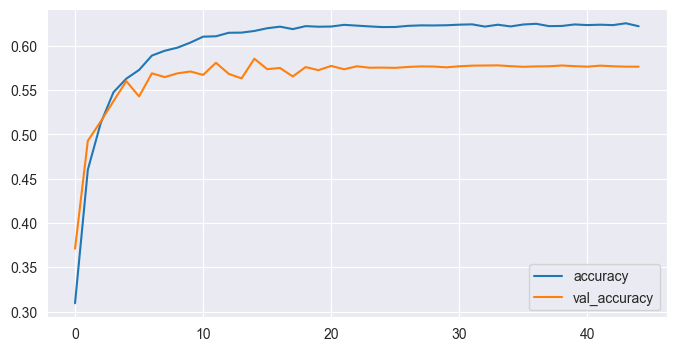

0.5855059623718262
0.6187455058097839
0.6175959706306458
0.6839402914047241
0.27390262484550476
0.431016206741333
0.47412118315696716
0.5993415713310242
0.26355311274528503
0.3297417461872101


In [15]:
def label_filter(X, y, erase_label):
    # 1. erase_label 제거
    keep_indices = y != erase_label
    X = X[keep_indices]
    y = y[keep_indices]

    # 2. erase_label보다 큰 값은 1씩 감소
    y = np.where(y > erase_label, y - 1, y)

    return X, y

def vis_graph(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

def heatmap_confusion_matrix(X_test, y_test, model):
    from sklearn.metrics import confusion_matrix
    # Predict class labels on the test set
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)  # convert softmax probs to predicted class
    y_true = y_test
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(np.max(y_test)+1), yticklabels=range(np.max(y_test)+1))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



X_train, y_train = label_filter(K8_X, K8_y, erase_label=0)
X_test_tmp, y_test_tmp = label_filter(X_test[0], y_test[0], erase_label=0)

model = Model.Original_model(X_train.shape[1:], num_class=np.max(y_train)+1)

history, model = Model.Train_model(
    model, X_train, y_train, X_test_tmp, y_test_tmp,
    set_epoch=100, set_batch_size=256, Model_name='V0',
    set_verbose=False, save_model_set=False
)
vis_graph(history)

ACC_lst = []
for i in range(8, len(f_lst)):
    X_tst, y_tst = label_filter(X_test[i-8], y_test[i-8], erase_label=0)
    acc = model.evaluate(X_tst, y_tst, verbose=0)[1]
    #heatmap_confusion_matrix(X_tst, y_tst, model)
    ACC_lst.append(acc)

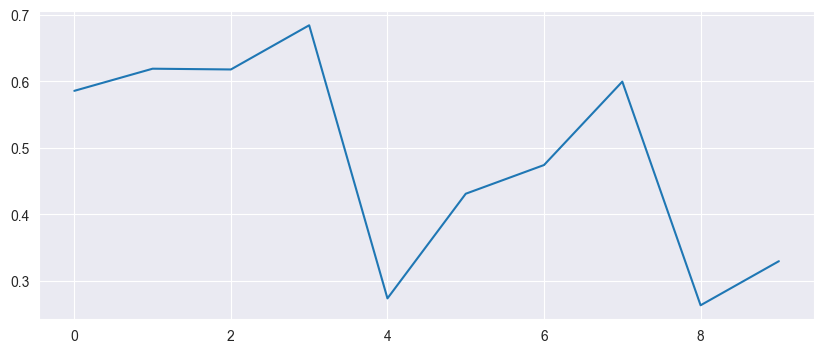

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(ACC_lst)
plt.show()

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 59.21%
Maximum validation accuracy : 56.43%


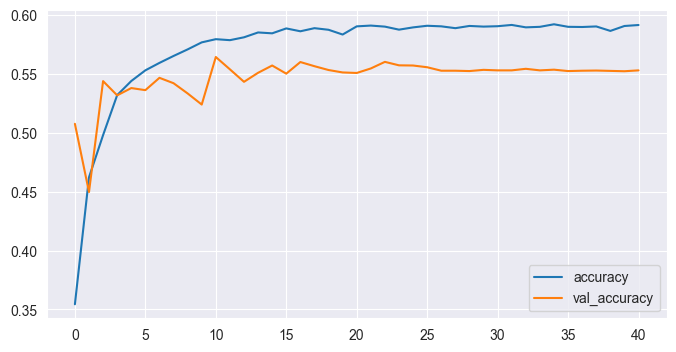

In [22]:
def label_filter(X, y, erase_label):
    # 1. erase_label 제거
    keep_indices = y != erase_label
    X = X[keep_indices]
    y = y[keep_indices]

    # 2. erase_label보다 큰 값은 1씩 감소
    y = np.where(y > erase_label, y - 1, y)

    return X, y

def vis_graph(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

def heatmap_confusion_matrix(X_test, y_test, model):
    from sklearn.metrics import confusion_matrix
    # Predict class labels on the test set
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)  # convert softmax probs to predicted class
    y_true = y_test
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(np.max(y_test)+1), yticklabels=range(np.max(y_test)+1))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


X_train, y_train = K8_X, K8_y
#X_train, y_train = label_filter(K8_X, K8_y, erase_label=0)
#X_test_tmp, y_test_tmp = label_filter(X_test[0], y_test[0], erase_label=0)

model = Model.Original_model(X_train.shape[1:], num_class=np.max(y_train)+1)

history, model = Model.Train_model(
    model, X_train, y_train, X_test_tmp, y_test_tmp,
    set_epoch=100, set_batch_size=256, Model_name='V0',
    set_verbose=False, save_model_set=False
)
vis_graph(history)

ACC_lst = []
for i in range(8, len(f_lst)):
    X_tst, y_tst = X_test[i-8], y_test[i-8]
    #X_tst, y_tst = label_filter(X_test[i-8], y_test[i-8], erase_label=0)
    acc = model.evaluate(X_tst, y_tst, verbose=0)[1]
    #heatmap_confusion_matrix(X_tst, y_tst, model)
    ACC_lst.append(acc)

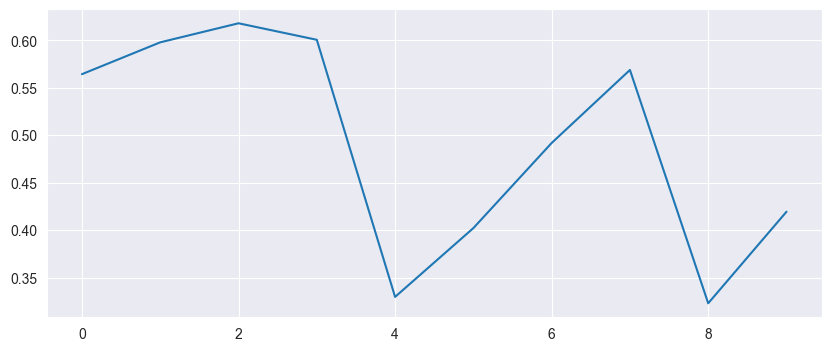

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(ACC_lst)
plt.show()

지금 문제가 0빼면 성능 매우 낮아짐 - 이걸 해소해야할 것 같음 - EMG로 하면 잘됬거든 (nono it was random split)

- 근데 real-time에서는 또 unbalance한게 중요함 - 동시에 0도 잘되어야하고 1,2,...n 다 잘되어야 해서 필요함
- 둘다 해야할듯
- 그래도 balance한 데이터에서 실험해야함
- 이상하게 ninapro 그거는 80퍼 나왔잖아 - 아 그건 random split이지